In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time # connaître le temps d'exécution
import os # récupérer le répertoire courant

from numpy import zeros
from numpy import sqrt
from numpy import pi
from numpy import cos
from numpy import exp
from numpy import sin
from numpy import linspace
from numpy import int32

from scipy import ndimage # pour la convolution

# Pour utiliser des fonctions d'autres fichiers jupyter
# sudo pip3 install ipynb
from ipynb.fs.full.mesFonctions import coefficientsDeriche
from ipynb.fs.full.mesFonctions import suppnonmaxima
from ipynb.fs.full.mesFonctions import seuillageParHysteresis

# sudo pip3 install imageio
from imageio import imread # lire l'image en uint8

# pip3 install opencv-python
import cv2 as cv

path = os.getcwd()
path=path[0:31]+"Donnees/"
print(path)

/home/damien/Bureau/Projet_TIM/Donnees/


#### Image originale

Dimensions image : n= 256  p= 256  z= 4


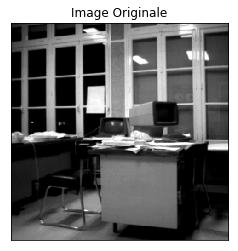

In [2]:
nomImage="office.png"
image = imread(path+nomImage) 

if (len(image.shape)==3):
    n,p,z=image.shape
    print("Dimensions image : n=", image.shape[0], " p=", image.shape[1], " z=", image.shape[2])
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY).astype(int32) # convertir l'image en niveaux de gris
elif (len(image.shape)==2):
    n,p=image.shape
    image=image.astype(np.float64)
    print("Dimensions image : n=", image.shape[0], " p=", image.shape[1])
else:
    print("Les données n'ont pas les bonnes dimensions")
#endif

plt.imshow(image,cmap = 'gray')
plt.title('Image Originale'), plt.xticks([]), plt.yticks([])
plt.show()

#### Choix des parametres (a modifier en fonction de l'image)

In [3]:
# parametres choisis page 179 de l'article pour l'image office.png
alpha = 1; 
omega = 0.0001;

#### Les coefficients du filtre

In [4]:
[c,k,c1,c2,b1,b2,a,a0,a1,a2,a3]=coefficientsDeriche(alpha,omega)

#### Réponses impulsionnelles $ f(x) $ et  $ h(x) $

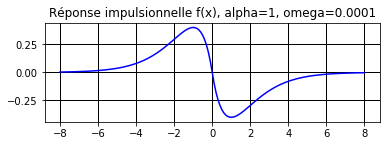

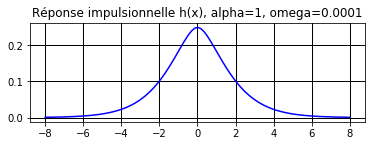

In [5]:
tailleIntervalle=int((8+8)/0.1+1)
intervalle=np.linspace(-8, 8, num=tailleIntervalle)

indice=-1
f=zeros([tailleIntervalle,1])
for i in intervalle:
    indice=indice+1
    f[indice]=-c*exp(-alpha*abs(i))*sin(omega*i)
#endfor

indice=-1
h=zeros([tailleIntervalle,1])
for j in intervalle:
    indice=indice+1
    h[indice]=(c1*sin(omega*abs(j))+c2*cos(omega*abs(j)))*exp(-alpha*abs(j))
#endfor

plt.subplot(211)
plt.grid(color='k', linestyle='-', linewidth=1)
plt.plot(intervalle,f,'b-')
plt.title('Réponse impulsionnelle f(x), alpha='+str(alpha)+', omega='+str(omega))
plt.show()

plt.subplot(212)
plt.grid(color='k', linestyle='-', linewidth=1)
plt.plot(intervalle,h,'b-')
plt.title('Réponse impulsionnelle h(x), alpha='+str(alpha)+', omega='+str(omega))
plt.show()

#### Reponse impulsionnelle f(n)

In [6]:
tailleIntervalle=int((n*p+n*p)/1+1)
intervalle=np.linspace(-n*p, n*p, num=tailleIntervalle)

indice=-1
f=zeros([tailleIntervalle,1])
for i in intervalle:
    indice=indice+1
    f[indice]=-c*exp(-alpha*abs(i))*sin(omega)*i
#endfor
f=f.T

#### Reponse impulsionnelle h(n)

In [7]:
indice=-1
h=zeros([tailleIntervalle,1])
for j in intervalle:
    indice=indice+1
    h[indice]=(c1*sin(omega*abs(j))+c2*cos(omega*abs(j)))*exp(-alpha*abs(j))
#endfor

#### Gradient X et Lissage

In [8]:
# 70.79 secondes (pas efficace)

#from scipy import signal
#temp = signal.convolve2d(image, np.rot90(f,2), mode='same')
#gradientX=signal.convolve2d(temp, np.rot90(h,2), mode='same')

temps_filtreDericheConvolutions 0.24159646034240723


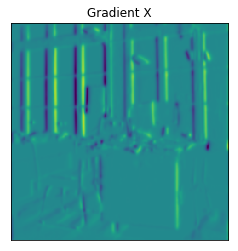

In [9]:
start_time=time.time()

temp= ndimage.convolve(image, np.rot90(f,2), mode='constant', cval=0.0)
# convolution horizontale f et image (donne gradient X)

gradientX= ndimage.convolve(temp, np.rot90(h,2), mode='constant', cval=0.0)
# lissage vertical (gradient X lisse)

temps_filtreDericheConvolutions=time.time()-start_time
print("temps_filtreDericheConvolutions",temps_filtreDericheConvolutions)

plt.imshow(gradientX)
plt.title('Gradient X'), plt.xticks([]), plt.yticks([])
plt.show()

#### Gradient Y et Lissage

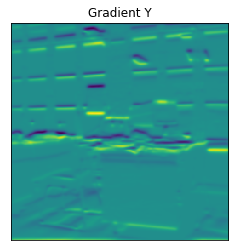

In [10]:
temp= ndimage.convolve(image.T, np.rot90(f,2), mode='constant', cval=0.0)
# convolution verticale f et image (donne gradient Y)

gradientY= ndimage.convolve(temp, np.rot90(h,2), mode='constant', cval=0.0)
# lissage horizontal (gradient Y lisse)

gradientY=gradientY.T

plt.imshow(gradientY)
plt.title('Gradient Y'), plt.xticks([]), plt.yticks([])
plt.show()

#### Norme du gradient (magnitude)

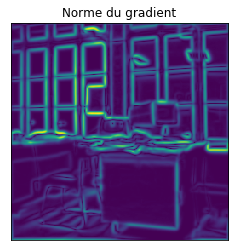

In [11]:
normeGradient = sqrt(pow(gradientX,2) + pow(gradientY,2))

plt.imshow(normeGradient)
plt.title('Norme du gradient'), plt.xticks([]), plt.yticks([])
plt.show()

#### Direction du gradient

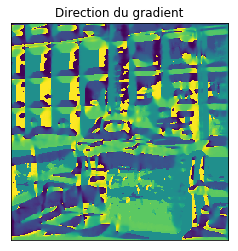

In [12]:
directionGradient = np.arctan2(gradientY,gradientX); # en radian
directionGradient = directionGradient*180/pi # conversion en degre

plt.imshow(directionGradient)
plt.title('Direction du gradient'), plt.xticks([]), plt.yticks([])
plt.show()

#### Suppression des non-maxima locaux

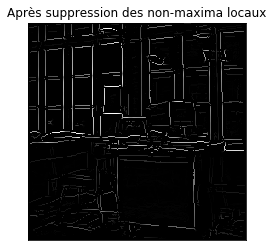

In [13]:
res_suppnonmax = suppnonmaxima(normeGradient, directionGradient)

plt.imshow(res_suppnonmax, cmap = 'gray')
plt.title('Après suppression des non-maxima locaux'), plt.xticks([]), plt.yticks([])
plt.show()

#### Hysteresis thresholding (using two thresholds)

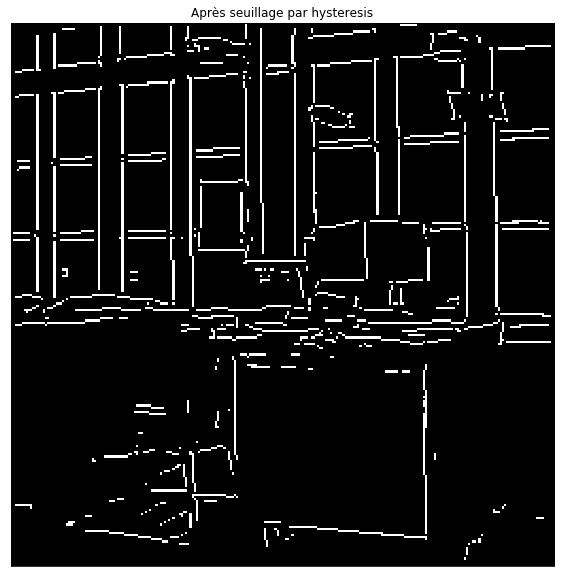

In [14]:
# Seuil minimum
Smin = 20

# Seuil maximum
Smax = 40

res = seuillageParHysteresis(res_suppnonmax, Smin, Smax)

plt.figure(figsize = (50,10))
plt.imshow(res, cmap = 'gray')
plt.title('Après seuillage par hysteresis'), plt.xticks([]), plt.yticks([])
plt.show()